# Estimate Hα velocity moment maps for NGC 346

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import astropy.units as u

In [2]:
sns.set_context("talk")

Load the data cube from the FITS file.

In [3]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))

In [4]:
import sys

In [5]:
from whispy import moments

In [6]:
moments.FIGPATH = Path("../../figs")
moments.SAVEPATH = Path("../../data")

## Select the wavelength range

Then take a narrow band about the H alpha line that avoids the flanking [N II] lines:

In [7]:
hacube = cube.select_lambda(6558.0, 6576.0)

Plot various aggregate measures over all the spatial pixels (mean, median, max, min):

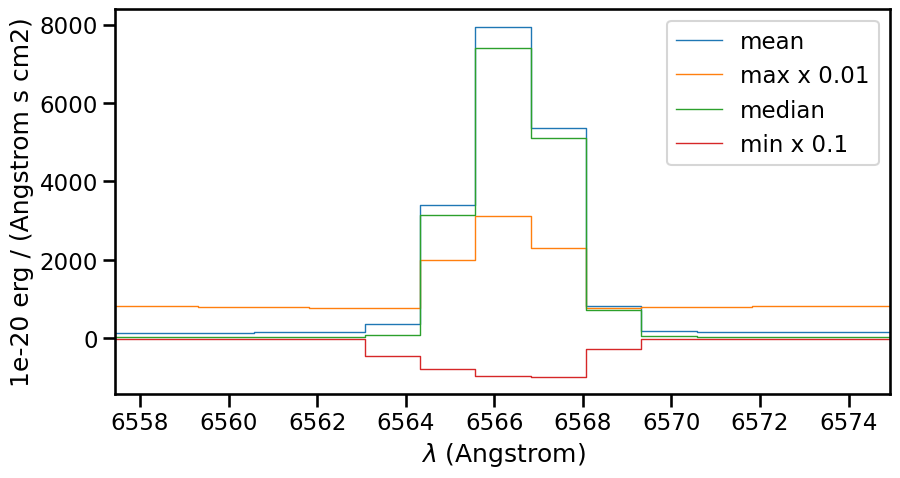

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
hacube.mean(axis=(1, 2)).plot(label="mean")
(0.01 * hacube.max(axis=(1, 2))).plot(label="max x 0.01")
hacube.median(axis=(1, 2)).plot(label="median")
(0.1 * hacube.min(axis=(1, 2))).plot(label="min x 0.1")
ax.legend()

## Subtract the continuum

On the plus side, it looks like there is never any significant continuum slope, so we can just calculate an average continuum level to subtract:

In [9]:
left_continuum = cube.select_lambda(6558.0, 6562.0).mean(axis=0)
right_continuum = cube.select_lambda(6572.0, 6576.0).mean(axis=0)
ha_cont = 0.5 * (left_continuum + right_continuum)

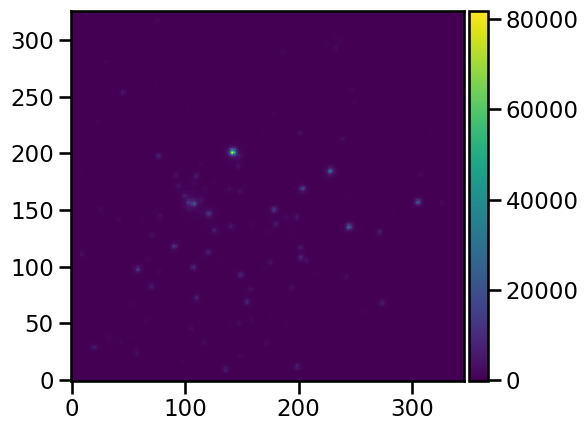

In [10]:
ha_cont.plot(colorbar="v")

Promote the continuum image to a cube by taking a copy of the the line cube and pasting in new data and variance:

In [11]:
contcube = hacube.copy()
contcube.data = np.ones_like(contcube.data) * ha_cont.data[None, :, :]
contcube.var = np.ones_like(contcube.var) * ha_cont.var[None, :, :]

Subtract the continuum.

In [12]:
hacube_contsub = hacube - contcube

Another way of doing it would have been to just subtract `ha_cont.data[None, :, :]` from the `.data` array of `hacube`.  But in that case, the `.var` would not have been propagated automatically and we would have to calculate it by hand.

Now we do the same plot:

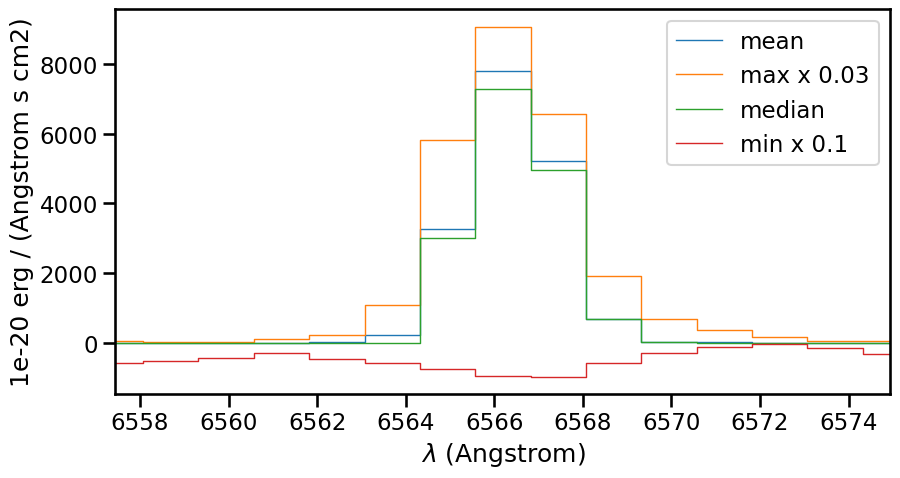

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
hacube_contsub.mean(axis=(1, 2)).plot(label="mean")
(0.03 * hacube_contsub.max(axis=(1, 2))).plot(label="max x 0.03")
hacube_contsub.median(axis=(1, 2)).plot(label="median")
(0.1 * hacube_contsub.min(axis=(1, 2))).plot(label="min x 0.1")
ax.legend()

This looks good – the continuum has been eliminated in all but the min aggregation, which is presumably dominated by a small number of pixels that have strange profiles.

## Make a cube of wavelengths

It is is easy to get a 1D array of the wavelengths:

In [14]:
waves = hacube_contsub.wave.coord()
waves

array([6557.44482422, 6558.69482422, 6559.94482422, 6561.19482422,
       6562.44482422, 6563.69482422, 6564.94482422, 6566.19482422,
       6567.44482422, 6568.69482422, 6569.94482422, 6571.19482422,
       6572.44482422, 6573.69482422, 6574.94482422])

But there seems no built-in way to get a cube of them, so we will construct it ourselves:

In [15]:
wavcube = hacube_contsub.clone(np.ones, np.zeros)
wavcube.data *= waves[:, None, None]
wavcube.unit = u.angstrom
wavcube.info()

[INFO] 15 x 326 x 346 Cube (no name)
[INFO] .data(15 x 326 x 346) (Angstrom), .var(15 x 326 x 346)
[INFO] center:(-72:10:31.85301606,00:59:02.98598354) size:(65.200",69.200") step:(0.200",0.200") rot:-0.0 deg frame:FK5
[INFO] wavelength: min:6557.44 max:6574.94 step:1.25 Angstrom


Note that we used the `.clone` method to get a new empty cube with the same coordinates, which we initialized with all ones as data and all zeros as variances (because there are no uncertainties in the wavelengths).  Then we used broadcasting to multiply the data by the 1D wavelength array and set the unit correctly.

## Calculate the moments

To reduce effects noise, especially in the higher moments, we use the core window of 6562 to 6572 in between the continuum-fitting ranges

In [16]:
hacore = hacube_contsub.select_lambda(6562.0, 6572.0)
wavcore = wavcube.select_lambda(6562.0, 6572.0)

The velocity moments are now trivial sums over this window.

In [17]:
mom0 = hacore.sum(axis=0)
wav0 = 6566.5
mom1 = mom0.copy()
mom1.data = np.sum(hacore.data * (wavcore.data - wav0), axis=0) / mom0.data
# mom1.mask = mom1.mask | (mom0.data < 0.0)

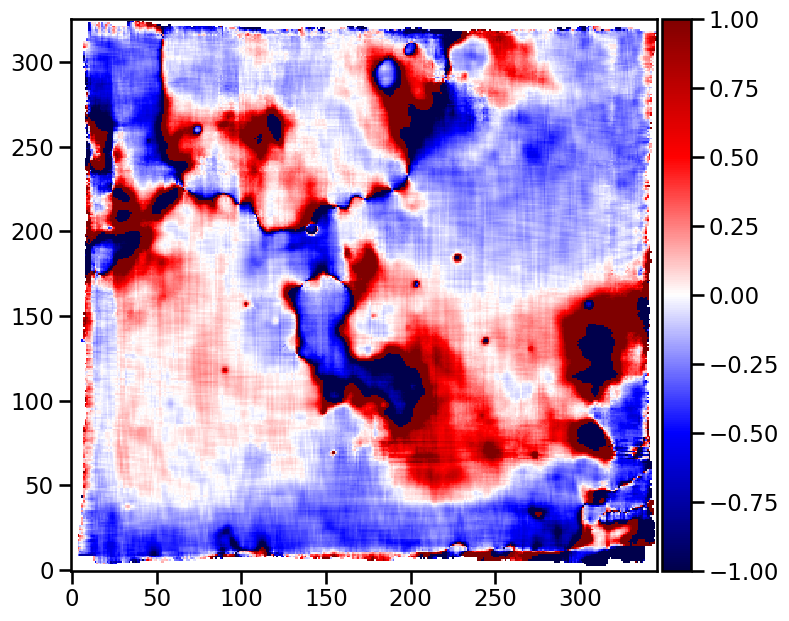

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
mom1.plot(
    cmap="seismic",
    vmin=-1.0,
    vmax=1.0,
    colorbar="v",
)

## Try and deal with sky over-subtraction

Look at where Ha brightness is negative, and overlay with positions of stars (continuum is high)

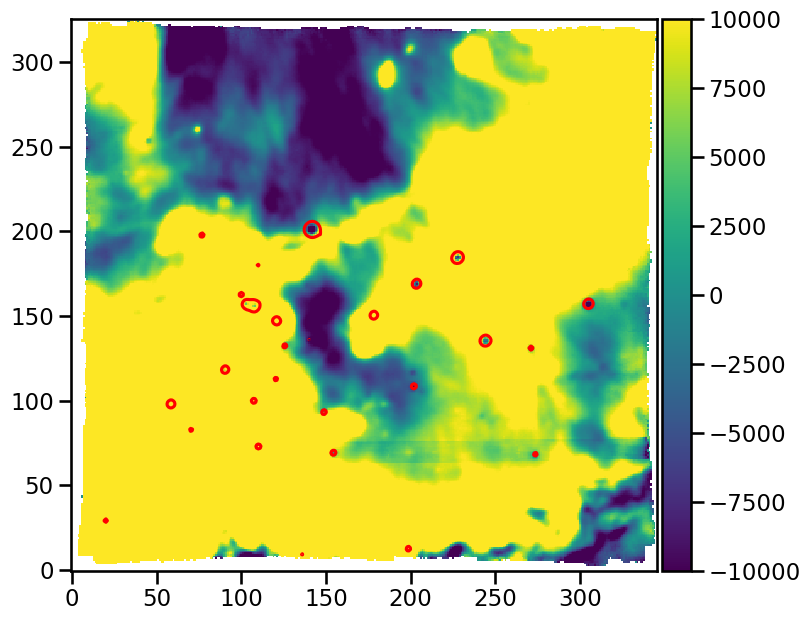

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
mom0.plot(
    #    vmin=0.5*mom0.data.min(),
    #    vmax=0.0,
    vmin=-10000,
    vmax=10000,
    cmap="viridis",
    colorbar="v",
)
ax.contour(ha_cont.data, levels=[5000], colors="r")

Look at some of the line profiles in the negative zones:

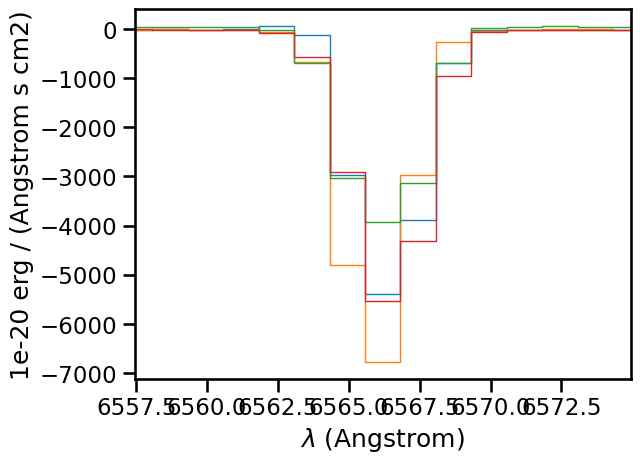

In [20]:
hacube[:, 300, 60].plot()
hacube[:, 10, 300].plot()
hacube[:, 150, 150].plot()
hacube[:, 260, 160].plot()

### Look for a strategy for finding a good sky profile

We want to find a profile that we can subtract from every pixel and it will give a decent profile.  By decent, I mean that it is almost exclusively positive (more or less) and doesn't look weirdly broad, narrow, or asymmetric.

I have tried various approaches. The best one seems to be selecting pixels that are (i) not strong continuum and (2) have integrated line flux < 20000

I test this out here on the 4 pixels that were selected as representative of those with negative line profiles (see previous graph).  It works OK at converting most of them to positive.  Three of them do still have small dips on the blue side, but these are very minor in two cases.  The only one that doesn't look good is the [10, 300] one.

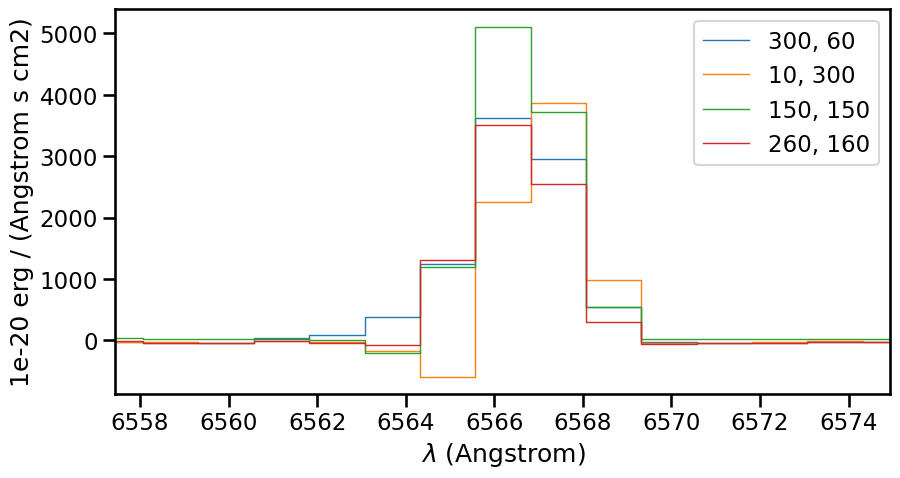

In [21]:
# skyspec = hacube[:, 10, 300]
starmask2d = ha_cont.data > 1000.0
bmask2d = hacore.sum(axis=0).data > -20000
skycube = hacube.copy()
skycube.mask = skycube.mask | starmask2d[None, :, :] | bmask2d[None, :, :]
skyspec = skycube.mean(axis=(1, 2))
fig, ax = plt.subplots(figsize=(10, 5))
for (j, i) in [[300, 60], [10, 300], [150, 150], [260, 160]]:
    (hacube[:, j, i] - skyspec).plot(label=f"{j}, {i}")
ax.legend()

It turns out that there are only 3 pixels that get used for the sky mask!  Here they are:

In [22]:
skymap = skycube.sum(axis=0)
np.where(~skymap.mask)

(array([8, 8, 8]), array([103, 104, 105]))

So, this is a map of the full wave range, including continuum, but with this sky spectrum subtracted:

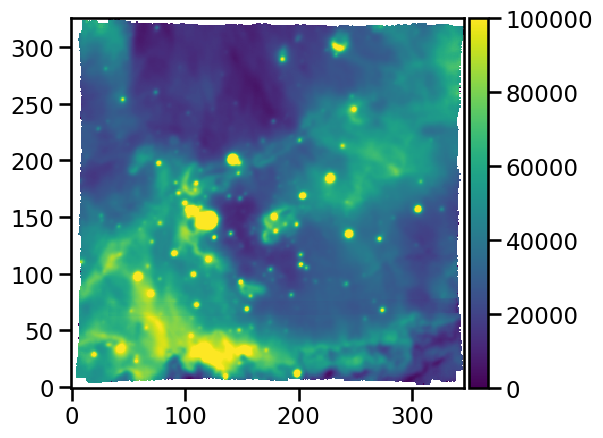

In [23]:
(hacube - skyspec).sum(axis=0).plot(vmin=0.0, vmax=1e5, colorbar="v")

And now we redo the moments of the continuum-subtracted core range, but subtracting skyspec first:

In [24]:
_hacube_contsub = hacube - contcube - skyspec
_hacore = _hacube_contsub.select_lambda(6562.0, 6572.0)
_mom0 = _hacore.sum(axis=0)
_mom1 = _mom0.copy()
_mom1.data = np.sum(_hacore.data * (wavcore.data - wav0), axis=0) / _mom0.data

Note that I prepend an underscore to all the variables for the sky-corrected versions.

Here is a map of the Ha intensity:

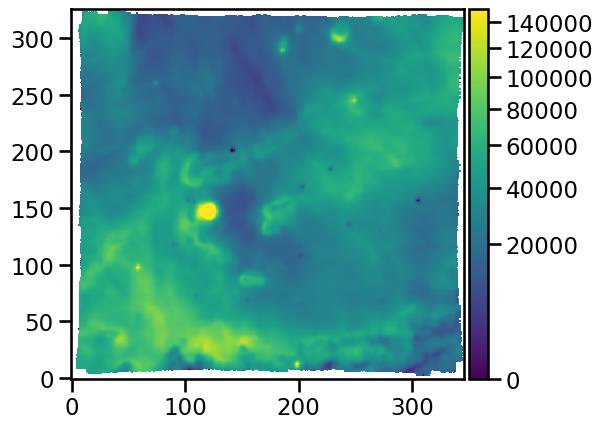

In [25]:
_mom0.plot(vmin=0.0, vmax=1.5e5, scale="sqrt", colorbar="v")

Looks good – at least, it does not go negative except for at some stars.

Now, we plot the first moment.  Note this is the wavelength shift from `wav0` in Å.  Multiply by about 50 to get velocity in km/s

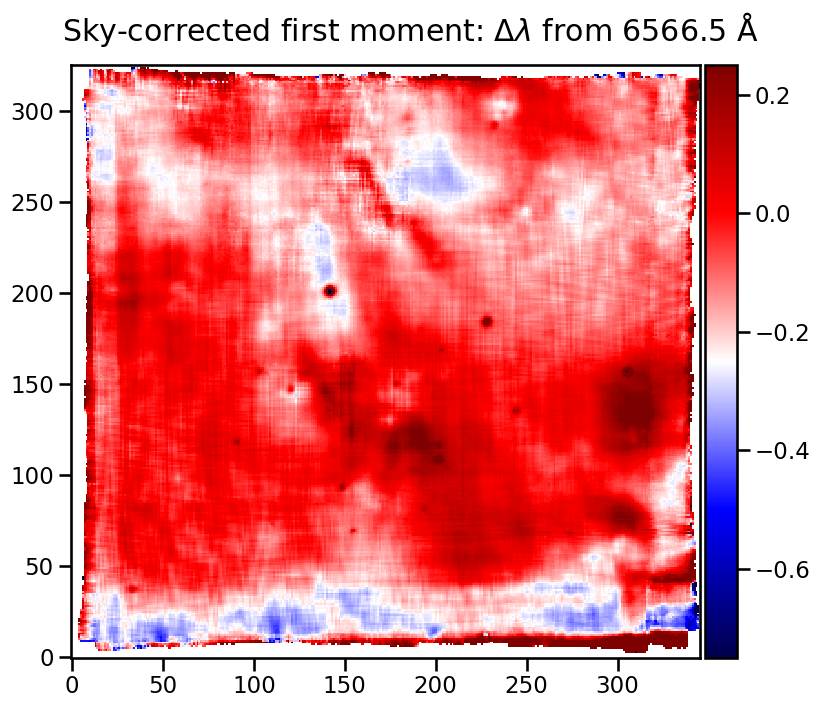

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
_mom1.plot(
    cmap="seismic",
    vmin=-0.75,
    vmax=0.25,
    colorbar="v",
)
fig.suptitle(
    f"Sky-corrected first moment: $\Delta\lambda$ from {wav0} Å",
    y=0.92,
)
fig.tight_layout(pad=0)

Maybe we can even trust this result, except for near the borders.

Next, here are a sampling of particular pixels.  Faint regions in the top row to bright regions in the bottom row. The blue line shows the original profile, while the orange line shows the profile after correcting the sky.

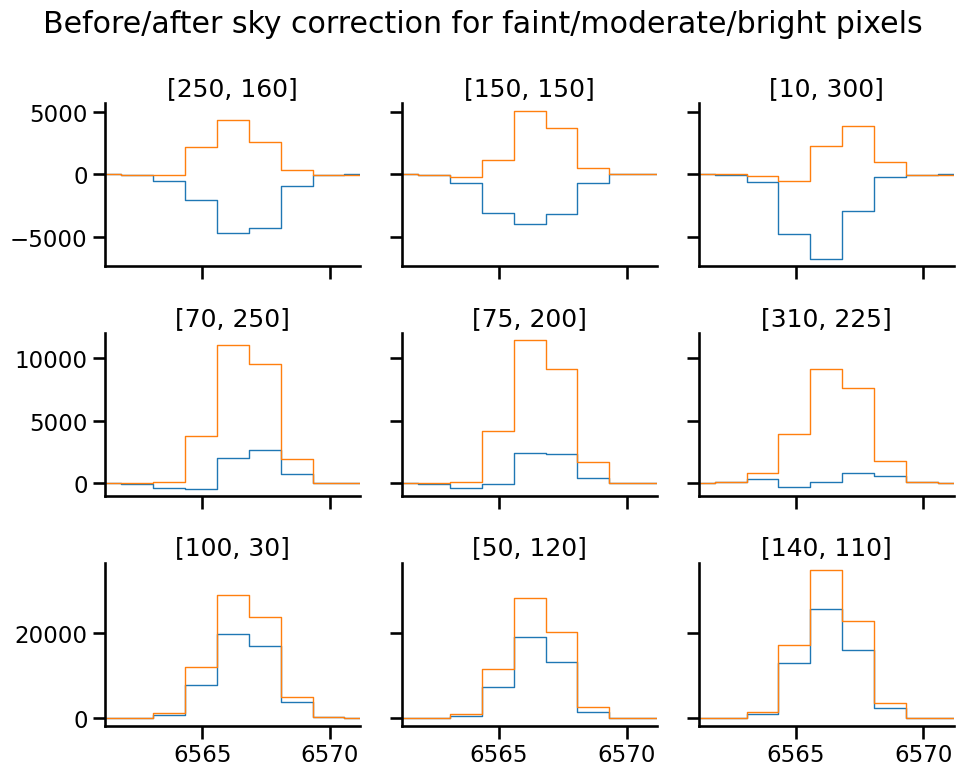

In [27]:
testpixels = [
    [250, 160],
    [150, 150],
    [10, 300],
    [70, 250],
    [75, 200],
    [310, 225],
    [100, 30],
    [50, 120],
    [140, 110],  # [180, 290],
]
fig, axes = plt.subplots(
    3,
    3,
    figsize=(10, 8),
    sharex=True,
    sharey="row",
)
for (j, i), ax in zip(testpixels, axes.flat):
    hacore[:, j, i].plot(ax=ax)
    _hacore[:, j, i].plot(ax=ax)
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"[{j}, {i}]")
fig.suptitle("Before/after sky correction for faint/moderate/bright pixels")
sns.despine()
fig.tight_layout()

The correction is a really large fraction of the total profile, except for the brightest pixels, which is rather scary.

### Try looking at joint distribution of unnormalized moments

The unnormalized moments should behave better since they can pass through zero without having the 0/0 problem. .

#### Before correcting the sky

In [28]:
mom0 = hacore.sum(axis=0)
mom1 = mom0.copy()
# wav0 = 6566.5
wav0 = 6566.6
mom1.data = np.sum(hacore.data * (wavcore.data - wav0), axis=0)
mom2 = mom0.copy()
mom2.data = np.sum(hacore.data * (wavcore.data - wav0) ** 2, axis=0)

Note that we do not divide `mom1` by `mom0`

In [29]:
import pandas as pd

In [30]:
sns.set_color_codes()

We mask out the brightest parts and also the outliers in velocity so that we can see the part that passes through zero better.

In [31]:
starmask = ha_cont.data > 1e4
m = starmask | mom0.mask | (mom0.data > 3e4) | (np.abs(mom1.data) > 1e4)
df = pd.DataFrame(
    {
        "mom0": mom0.data[~m],
        "mom1": mom1.data[~m],
        "mom2": mom2.data[~m],
    }
)
df.describe()

,mom0,mom1,mom2
count,75503.000000,75503.000000,75503.000000
mean,7644.038689,-694.515483,5846.967404
std,11574.557320,3787.111728,15501.625025
min,-23961.928188,-9999.811775,-79087.283453
25%,-1636.873354,-3057.364577,-5968.545619
50%,7118.550131,-128.920670,4679.404027
75%,16757.916761,1934.835455,17292.856219
max,29998.171920,9997.417081,63102.143548


Make a corner plot of the moment distributions:

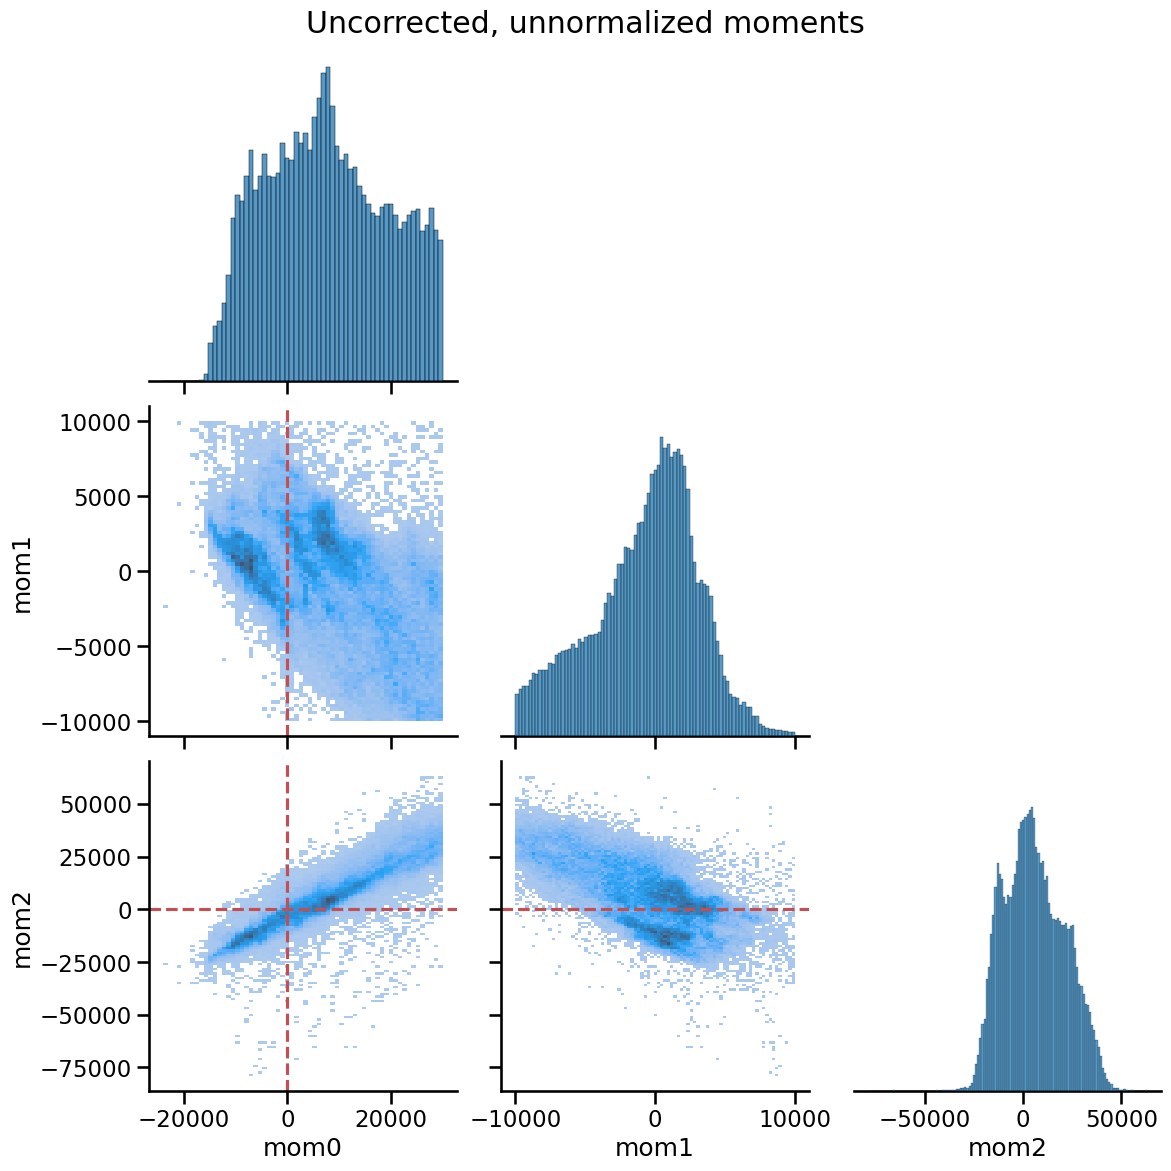

In [32]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r", linestyle="dashed")
g.axes[2, 0].axvline(0.0, color="r", linestyle="dashed")
g.axes[2, 0].axhline(0.0, color="r", linestyle="dashed")
g.axes[2, 1].axhline(0.0, color="r", linestyle="dashed")
g.fig.suptitle("Uncorrected, unnormalized moments")
g.tight_layout()

Note that for an emission line, mom0 and mom2 should be positive definite.  They are not, which clearly shows the proplem.

In principle, the sky correction should add constant values to all 3 un-normalized moments (that is, constant with position).  We can see more-or-less what must be added to mom0 and mom2 to make them always, positive but with mom1 there is no requirement that the value should be positive (and it is relative to our aribitrary `wav0` anyway).

However, so long as we get mom0 and mom2 right, I think that it doen't matter if there is a systematic uncertainty in mom1, since the relative velocities will be unaffected.

#### After correcting the sky

Now, we do it on the data that has supposedly been corrected for the bad sky.  **I adjust the reference wavelength to 6566.4 instead of 6566.6**. This is to better center the velocity distribution

In [33]:
_mom0 = _hacore.sum(axis=0)
_mom1 = _mom0.copy()
wav0 = 6566.4
_mom1.data = np.sum(_hacore.data * (wavcore.data - wav0), axis=0)
_mom2 = _mom0.copy()
_mom2.data = np.sum(_hacore.data * (wavcore.data - wav0) ** 2, axis=0)

We take a less restrictive mask, only masking out the outliers in any of the moments:

In [34]:
m = (
    starmask
    | _mom0.mask
    | (_mom0.data > 15e4)
    | (_mom1.data < -2e4)
    | (_mom1.data > 2e4)
    | (_mom2.data < -1e4)
    | (_mom2.data > 1.5e5)
)
df = pd.DataFrame(
    {
        "mom0": _mom0.data[~m],
        "mom1": _mom1.data[~m],
        "mom2": _mom2.data[~m],
    }
)
df.describe()

,mom0,mom1,mom2
count,103975.000000,103975.000000,103975.000000
mean,38330.622242,686.745662,44693.469137
std,18903.744837,4608.308173,25006.960880
min,-2242.896124,-19982.847321,-9996.741679
25%,23560.064321,-1821.485709,26108.162186
50%,35272.026678,825.280718,40043.093905
75%,51255.607445,3919.532286,60866.266118
max,129060.545189,19977.589682,149880.745732


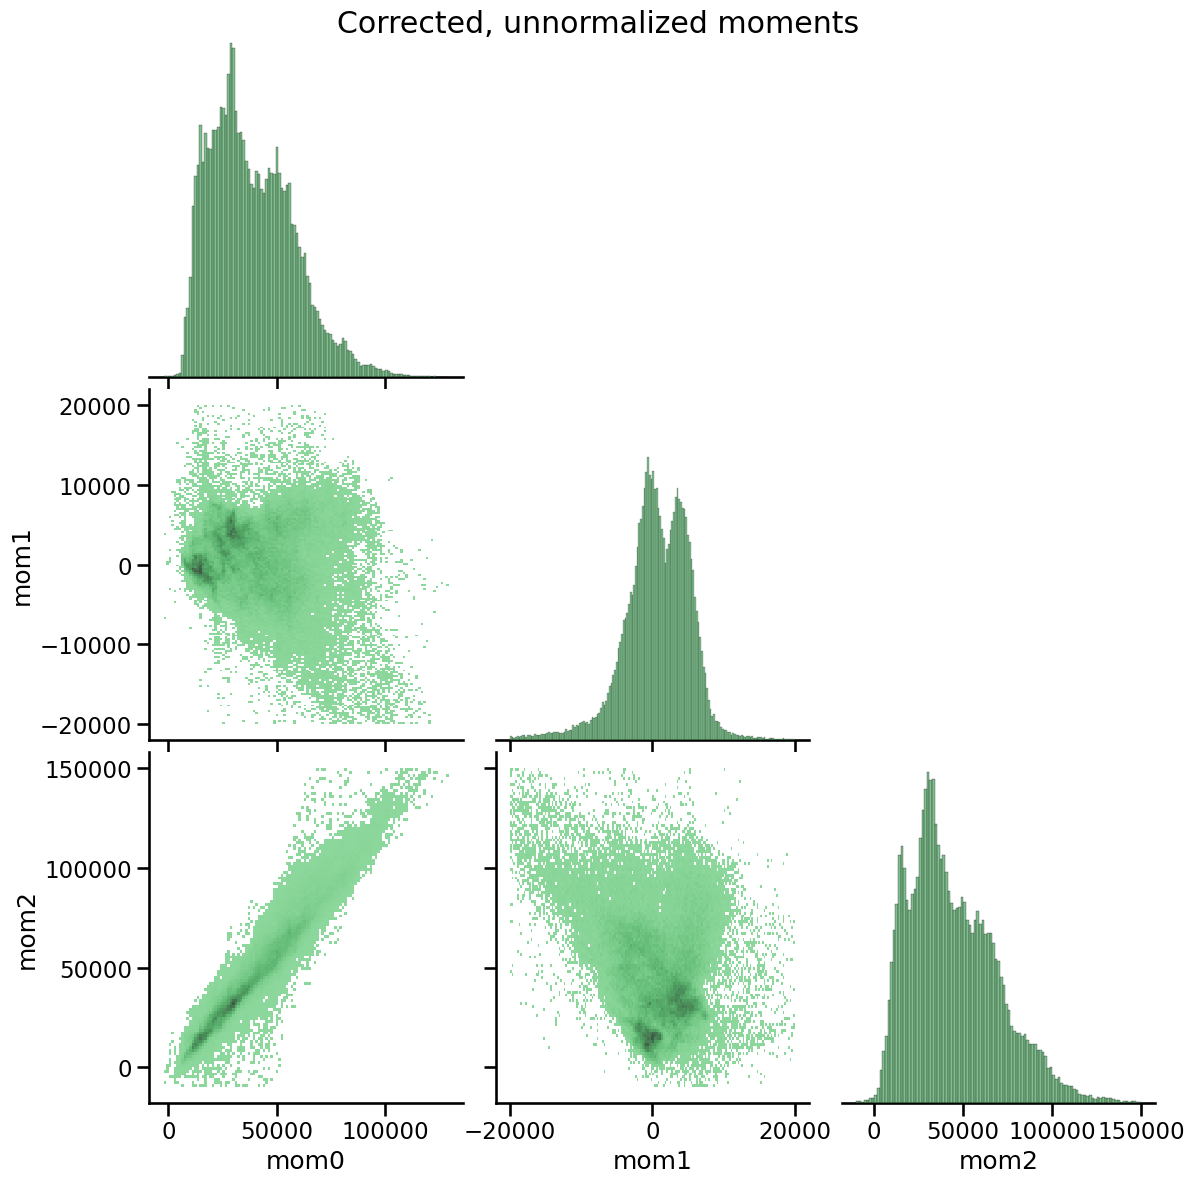

In [35]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="g"),
    diag_kws=dict(color="g"),
)
g.fig.suptitle("Corrected, unnormalized moments")
g.tight_layout(pad=0)

So that looks like it has worked. Note that mom1 fans out as a triangle as mom0 increases, but it stays roughly centered on zero. This is because of the judicious adjustment to wav0 above.

#### Back to normalized moments again

If that is sorted, then we should be able to look at the normalized moments:

In [36]:
_mom0 = _hacore.sum(axis=0)
_mom1 = _mom0.copy()
_mom1.data = np.sum(_hacore.data * (wavcore.data - wav0), axis=0) / _mom0.data
_mom2 = _mom0.copy()
_mom2.data = (
    np.sum(_hacore.data * (wavcore.data - wav0 - _mom1.data) ** 2, axis=0) / _mom0.data
)

In [37]:
m = (
    starmask
    | _mom0.mask
    | (_mom0.data < 0.6e4)
    | (_mom0.data > 15e4)
    | (_mom1.data < -0.4)
    | (_mom1.data > 0.4)
    | (_mom2.data > 1.75)
    | (_mom2.data < 0.5)
)
KMS_PER_ANGSTROM = 3e5 / 6563.0
df2 = pd.DataFrame(
    {
        "log10 I(Ha)": np.log10(_mom0.data[~m]),
        "V(Ha)": _mom1.data[~m] * KMS_PER_ANGSTROM,
        "sig(Ha)": np.sqrt(_mom2.data[~m]) * KMS_PER_ANGSTROM,
    }
)
df2.describe()

,log10 I(Ha),V(Ha),sig(Ha)
count,101952.000000,101952.000000,101952.000000
mean,4.535544,1.099169,48.312027
std,0.230632,5.316233,3.999056
min,3.784842,-18.182147,32.328698
25%,4.384087,-2.772384,46.220709
50%,4.555842,1.164963,48.421520
75%,4.714226,4.796117,50.711899
max,5.176052,18.256754,60.464665


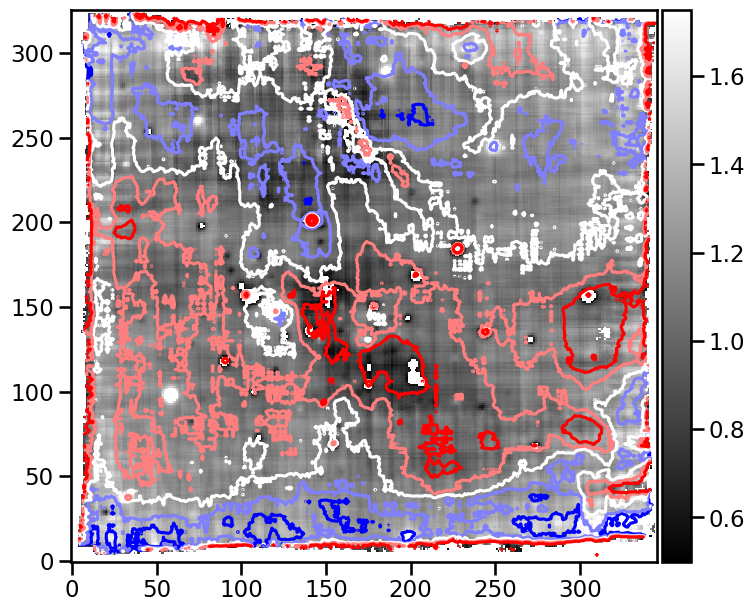

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
_mom2.mask = _mom2.mask | m
_mom2.plot(
    cmap="gray",
    vmin=0.5,
    vmax=1.75,
    colorbar="v",
)
ax.contour(KMS_PER_ANGSTROM * _mom1.data, levels=[-10, -5, 0, 5, 10], cmap="bwr")

## Redo it all using my moments library

Lots of the above can be done more easily now:

In [39]:
mom6563 = moments.find_moments(_hacore)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


In [40]:
mom6563[0].info()

[INFO] 326 x 346 Image (/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/ADP.2017-10-16T11_04_19.247.fits)
[INFO] .data(326 x 346) (1e-20 erg / (Angstrom s cm2)), .var(326 x 346)
[INFO] center:(-72:10:31.85301606,00:59:02.98598354) size:(65.200",69.200") step:(0.200",0.200") rot:-0.0 deg frame:FK5


In [41]:
mom_pars_6563 = dict(
    restwav=6562.79,
    irange=[3.0e3, 1.0e6],
    vrange=[135, 195],
    srange=[30, 70],
)

In [42]:
moments.save_moments_to_fits(
    mom6563,
    label="6563",
    flabel="ngc346-hi",
    **mom_pars_6563,
)

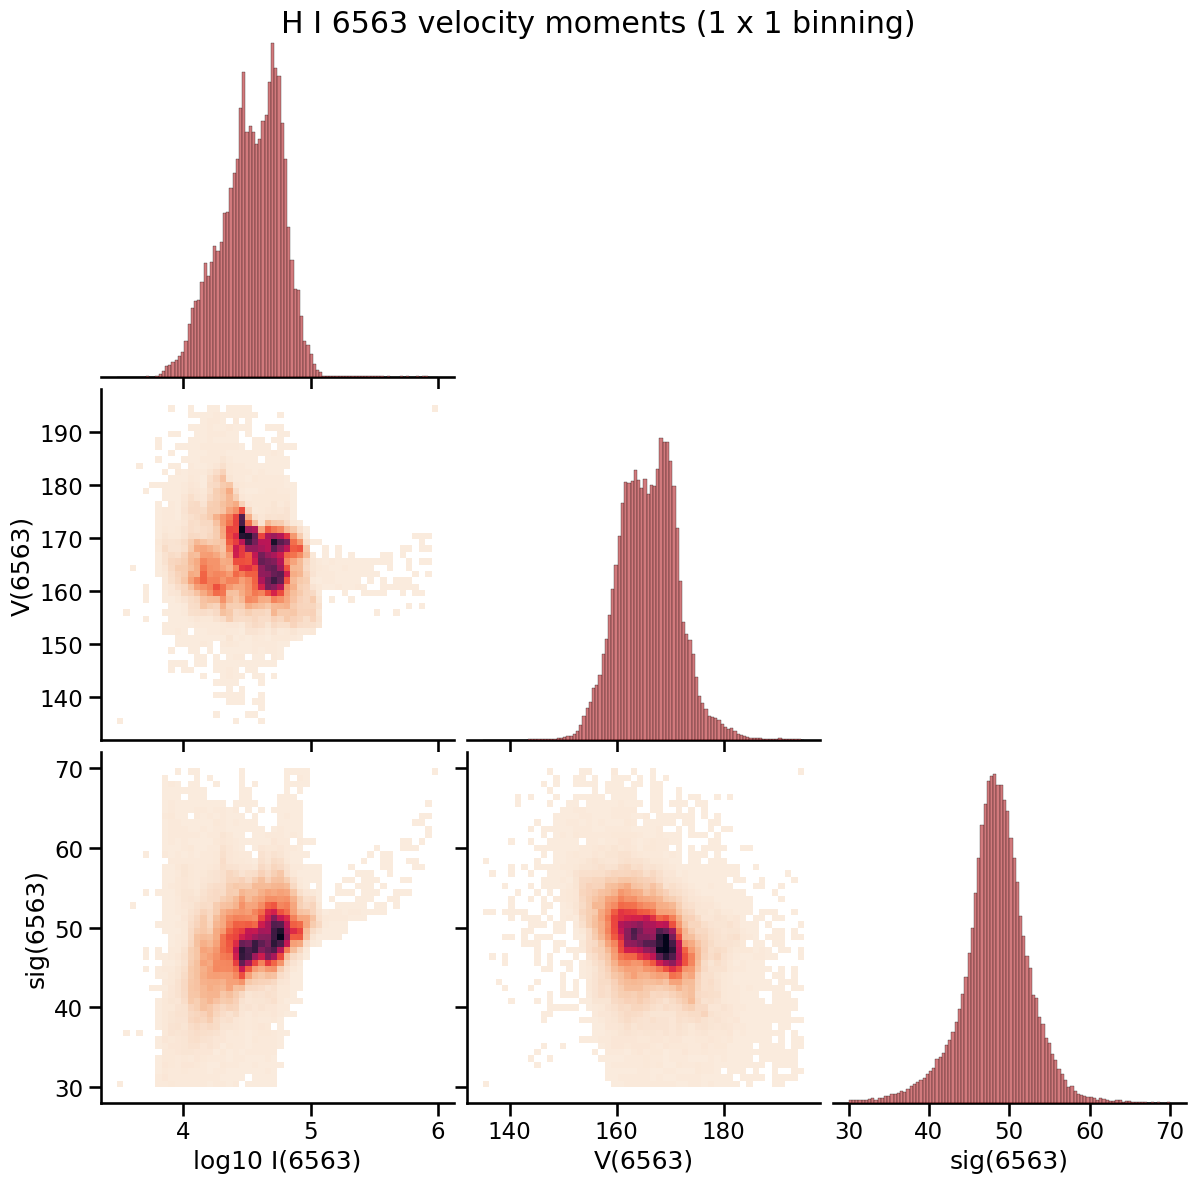

In [43]:
plot_pars_6563 = dict(
    ilabel="H I",
    label="6563",
    flabel="ngc346-hi",
    **mom_pars_6563,
)
g = moments.moments_corner_plot(mom6563, rebin=1, **plot_pars_6563)

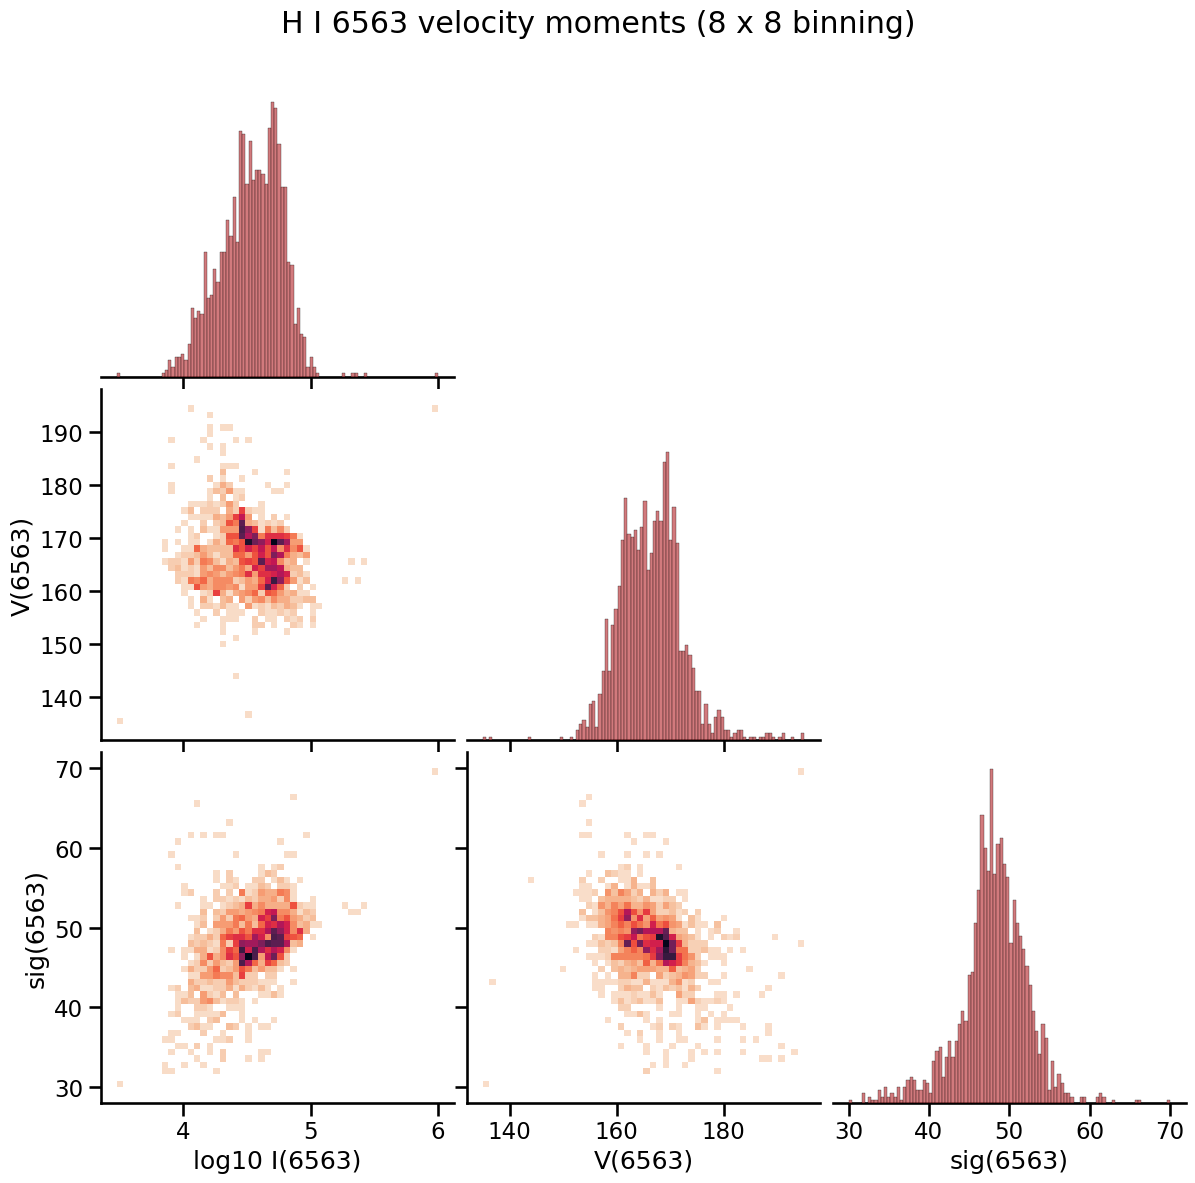

In [44]:
g = moments.moments_corner_plot(mom6563, rebin=8, **plot_pars_6563)